In [4]:
import pandas as pd

def load_and_merge_transaction_identity(transactions_csv, identity_csv):
    """
    Load transaction and identity data, merge on TransactionID.
    Fill missing values for key fields.
    """
    # Load transaction data (including 'isFraud')
    transactions = pd.read_csv(transactions_csv, usecols=['TransactionID', 'card1', 'isFraud'])

    # Load identity data with device info
    identity = pd.read_csv(identity_csv, usecols=['TransactionID', 'DeviceType', 'DeviceInfo'])

    # Merge on TransactionID
    df = transactions.merge(identity, on='TransactionID', how='left')

    # Fill missing values with 'unknown'
    df.fillna('unknown', inplace=True)

    # Convert key columns to string
    df['card1'] = df['card1'].astype(str)
    df['DeviceType'] = df['DeviceType'].astype(str)
    df['DeviceInfo'] = df['DeviceInfo'].astype(str)

    return df


In [6]:

df = load_and_merge_transaction_identity(
    '../data/train_transaction.csv',
    '../data/train_identity.csv'
)

print(df.head())
print(df['isFraud'].value_counts())


   TransactionID  isFraud  card1 DeviceType                     DeviceInfo
0        2987000        0  13926    unknown                        unknown
1        2987001        0   2755    unknown                        unknown
2        2987002        0   4663    unknown                        unknown
3        2987003        0  18132    unknown                        unknown
4        2987004        0   4497     mobile  SAMSUNG SM-G892A Build/NRD90M
isFraud
0    569877
1     20663
Name: count, dtype: int64


In [7]:
import networkx as nx

def build_transaction_entity_graph(df):
    """
    Builds a bipartite graph:
    - Nodes: TransactionIDs and entity nodes (card1, DeviceType, DeviceInfo)
    - Edges: Between transactions and their entities
    """
    G = nx.Graph()

    for _, row in df.iterrows():
        txn_id = f"txn_{int(row['TransactionID'])}"
        G.add_node(txn_id, node_type='transaction', isFraud=row['isFraud'])

        # Link to card
        card_node = f"card_{row['card1']}"
        G.add_node(card_node, node_type='card')
        G.add_edge(txn_id, card_node)

        # Link to DeviceType
        if row['DeviceType'] != 'unknown':
            device_node = f"device_{row['DeviceType']}"
            G.add_node(device_node, node_type='device_type')
            G.add_edge(txn_id, device_node)

        # Link to DeviceInfo
        if row['DeviceInfo'] != 'unknown':
            devinfo_node = f"devinfo_{row['DeviceInfo']}"
            G.add_node(devinfo_node, node_type='device_info')
            G.add_edge(txn_id, devinfo_node)

    return G


In [8]:
# Build graph
G = build_transaction_entity_graph(df)

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Optional: Check a random fraudulent transaction and its neighbors
fraudulent_nodes = [n for n, attr in G.nodes(data=True) if attr.get('isFraud') == 1]
print(f"Found {len(fraudulent_nodes)} fraudulent transactions in the graph.")

if fraudulent_nodes:
    example_fraud = fraudulent_nodes[0]
    print(f"Example fraudulent transaction: {example_fraud}")
    print(f"Neighbors: {list(G.neighbors(example_fraud))}")

Graph has 605881 nodes and 850016 edges.
Found 20663 fraudulent transactions in the graph.
Example fraudulent transaction: txn_2987203
Neighbors: ['card_18268']


In [9]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_transaction_neighborhood(G, transaction_node, depth=1):
    """
    Visualize the neighborhood of a given transaction node up to a certain depth.
    """
    # Get nodes within `depth` steps from the transaction
    ego_net = nx.ego_graph(G, transaction_node, radius=depth)

    pos = nx.spring_layout(ego_net, seed=42)

    # Node coloring based on type
    node_colors = []
    for node, attr in ego_net.nodes(data=True):
        if attr.get('node_type') == 'transaction':
            if attr.get('isFraud') == 1:
                node_colors.append('red')
            else:
                node_colors.append('lightblue')
        else:
            node_colors.append('lightgreen')

    plt.figure(figsize=(10, 8))
    nx.draw(ego_net, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=8, edge_color='gray')
    plt.title(f"Neighborhood of Transaction {transaction_node} (Depth {depth})")
    plt.show()


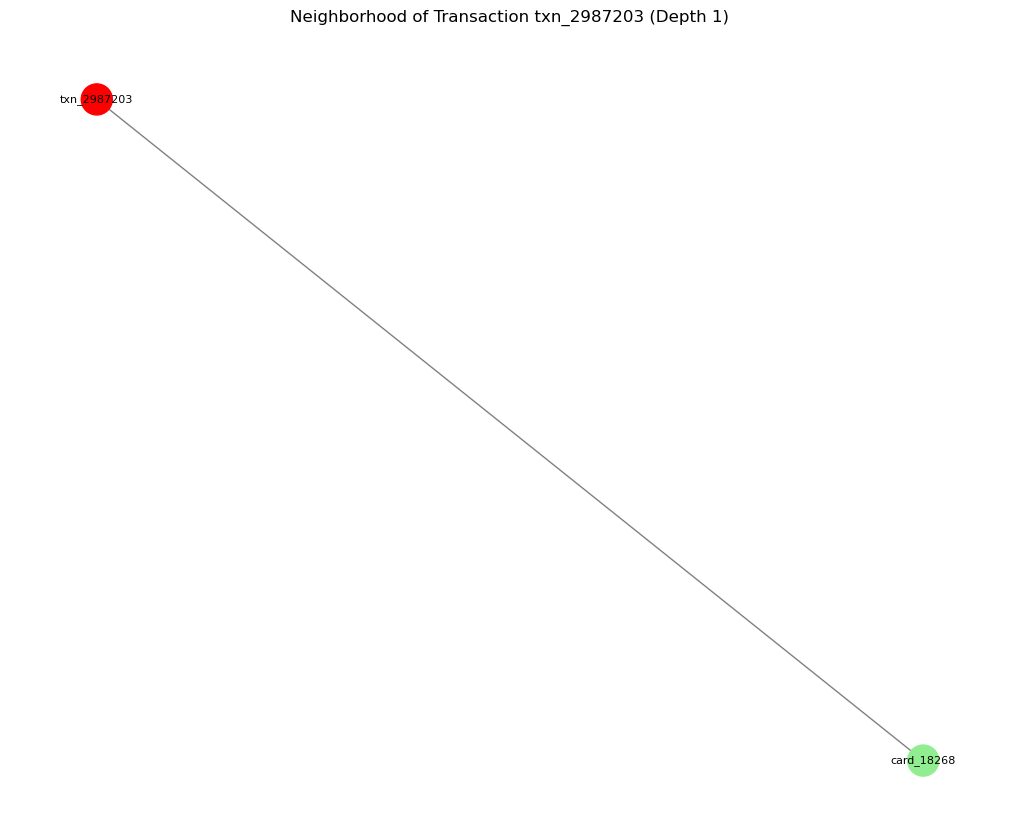

In [12]:
# Visualize first fraudulent transaction's neighborhood
if fraudulent_nodes:
    visualize_transaction_neighborhood(G, fraudulent_nodes[0], depth=1)

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_transaction_only_neighborhood(G, transaction_node, depth=2):
    """
    Visualize transaction nodes connected within a certain depth from a given transaction.
    Only displays transaction nodes.
    """
    # Get ego network within depth
    ego_net = nx.ego_graph(G, transaction_node, radius=depth)

    # Filter for transaction nodes only
    txn_nodes = [n for n, attr in ego_net.nodes(data=True) if attr.get('node_type') == 'transaction']
    txn_subgraph = G.subgraph(txn_nodes)

    if len(txn_subgraph) == 0:
        print("No transaction nodes found within this depth.")
        return

    # Layout
    pos = nx.spring_layout(txn_subgraph, seed=42)

    # Node coloring based on fraud status
    node_colors = []
    for node, attr in txn_subgraph.nodes(data=True):
        if attr.get('isFraud') == 1:
            node_colors.append('red')
        else:
            node_colors.append('lightblue')

    plt.figure(figsize=(10, 8))
    nx.draw(txn_subgraph, pos, with_labels=True, node_color=node_colors,
            node_size=500, font_size=8, edge_color='gray')
    plt.title(f"Filtered Neighborhood of Transaction {transaction_node} (Depth {depth}) - Transactions Only")
    plt.show()


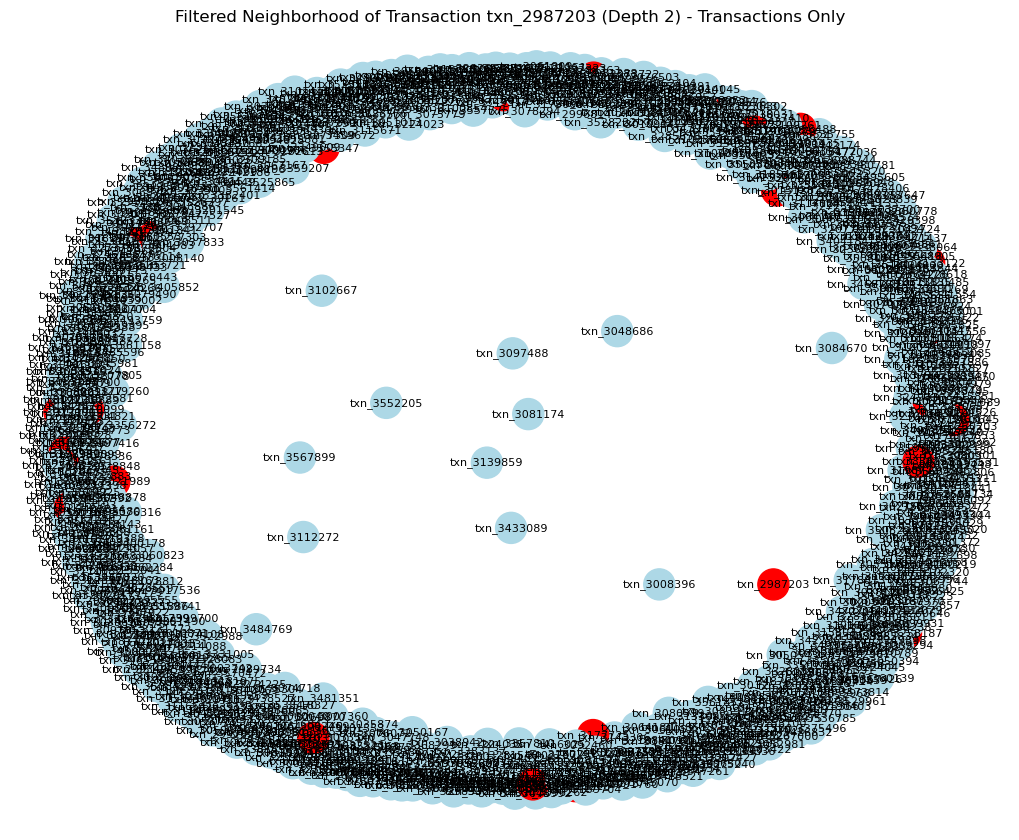

In [14]:
# Visualize with only transactions shown
if fraudulent_nodes:
    visualize_transaction_only_neighborhood(G, fraudulent_nodes[0], depth=2)

In [15]:
import networkx as nx

def bfs_find_neighboring_transactions(G, start_node, max_depth=2):
    """
    Perform BFS starting from start_node, collecting neighboring transaction nodes up to max_depth.
    Only transaction nodes are collected.
    """
    visited = set()
    queue = [(start_node, 0)]  # (node, current_depth)
    result = []

    while queue:
        current_node, depth = queue.pop(0)
        if current_node in visited:
            continue
        visited.add(current_node)

        # Collect if it's a transaction node (but skip the starting node itself)
        if G.nodes[current_node].get('node_type') == 'transaction' and current_node != start_node:
            result.append({
                'transaction_id': current_node,
                'isFraud': G.nodes[current_node].get('isFraud'),
                'depth': depth
            })

        if depth < max_depth:
            neighbors = G.neighbors(current_node)
            for neighbor in neighbors:
                if neighbor not in visited:
                    queue.append((neighbor, depth + 1))

    return result


In [16]:
# Explore neighbors of the first fraudulent transaction
if fraudulent_nodes:
    neighbors = bfs_find_neighboring_transactions(G, fraudulent_nodes[0], max_depth=2)

    print(f"Found {len(neighbors)} neighboring transactions within 2 hops.")
    for neighbor in neighbors[:10]:  # Show first 10
        print(neighbor)

Found 1129 neighboring transactions within 2 hops.
{'transaction_id': 'txn_2989213', 'isFraud': 0, 'depth': 2}
{'transaction_id': 'txn_2989310', 'isFraud': 0, 'depth': 2}
{'transaction_id': 'txn_2989316', 'isFraud': 0, 'depth': 2}
{'transaction_id': 'txn_2989599', 'isFraud': 0, 'depth': 2}
{'transaction_id': 'txn_2989734', 'isFraud': 0, 'depth': 2}
{'transaction_id': 'txn_2990418', 'isFraud': 0, 'depth': 2}
{'transaction_id': 'txn_2991760', 'isFraud': 0, 'depth': 2}
{'transaction_id': 'txn_2993497', 'isFraud': 0, 'depth': 2}
{'transaction_id': 'txn_2995063', 'isFraud': 0, 'depth': 2}
{'transaction_id': 'txn_2995122', 'isFraud': 0, 'depth': 2}


In [18]:

def analyze_fraud_clustering(G, transaction_nodes, max_depth=2):
    """
    For each transaction node, count the number of fraudulent neighboring transactions.
    Returns a list of dicts with transaction_id, isFraud, fraud_neighbor_count.
    """
    clustering_data = []

    for txn_node in transaction_nodes:
        neighbors = bfs_find_neighboring_transactions(G, txn_node, max_depth=max_depth)
        fraud_neighbor_count = sum(1 for n in neighbors if n['isFraud'] == 1)

        clustering_data.append({
            'transaction_id': txn_node,
            'isFraud': G.nodes[txn_node].get('isFraud'),
            'fraud_neighbor_count': fraud_neighbor_count
        })

    return clustering_data


In [30]:
# Get all transaction nodes (you may want to sample for performance)
transaction_nodes = [n for n, attr in G.nodes(data=True) if attr.get('node_type') == 'transaction']

# Analyze clustering for a sample (e.g., 5000 transactions)
import random
sampled_nodes = random.sample(transaction_nodes, 50)

clustering_results = analyze_fraud_clustering(G, sampled_nodes, max_depth=3)

# Convert to DataFrame for analysis
import pandas as pd
df_clustering = pd.DataFrame(clustering_results)

print(df_clustering.head())

  transaction_id  isFraud  fraud_neighbor_count
0    txn_3373787        0                    22
1    txn_3240767        0                  5689
2    txn_3135804        0                  5859
3    txn_3409156        0                   112
4    txn_3550221        0                  5657


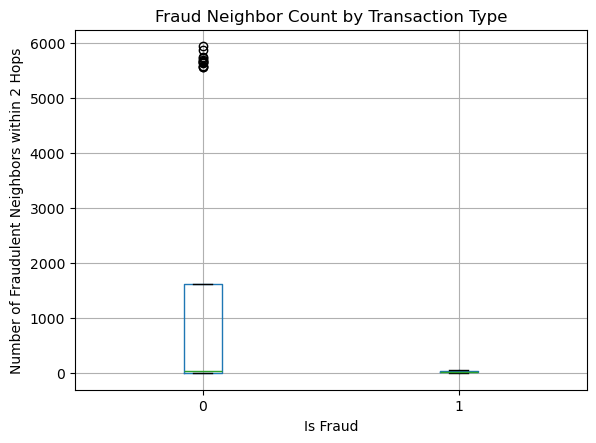

In [31]:
import matplotlib.pyplot as plt

# Boxplot comparing fraud_neighbor_count for fraud vs non-fraud transactions
df_clustering.boxplot(column='fraud_neighbor_count', by='isFraud')
plt.title('Fraud Neighbor Count by Transaction Type')
plt.suptitle('')
plt.xlabel('Is Fraud')
plt.ylabel('Number of Fraudulent Neighbors within 2 Hops')
plt.show()


In [32]:
from scipy.stats import ttest_ind

frauds = df_clustering[df_clustering['isFraud'] == 1]['fraud_neighbor_count']
legit = df_clustering[df_clustering['isFraud'] == 0]['fraud_neighbor_count']

t_stat, p_value = ttest_ind(frauds, legit, equal_var=False)
print(f"T-test result: t-statistic = {t_stat:.2f}, p-value = {p_value:.4f}")


T-test result: t-statistic = -3.99, p-value = 0.0002


At shallow depths (1–2): Fraud neighbors might not show a strong difference — possibly due to noise from shared cards/devices.

At depth 3:
You’re capturing extended fraud rings — maybe via multi-step relationships — where fraud transactions are indirectly connected through shared entities.

In [33]:
fraud_degrees = [G.degree(n) for n in transaction_nodes if G.nodes[n].get('isFraud') == 1]
legit_degrees = [G.degree(n) for n in transaction_nodes if G.nodes[n].get('isFraud') == 0]

# t-test on degrees
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(fraud_degrees, legit_degrees, equal_var=False)
print(f"Degree T-test: t = {t_stat:.2f}, p = {p_value:.4f}")


Degree T-test: t = 81.83, p = 0.0000


Fraudulent transactions have, on average, a different number of connections (degree) than legitimate transactions.

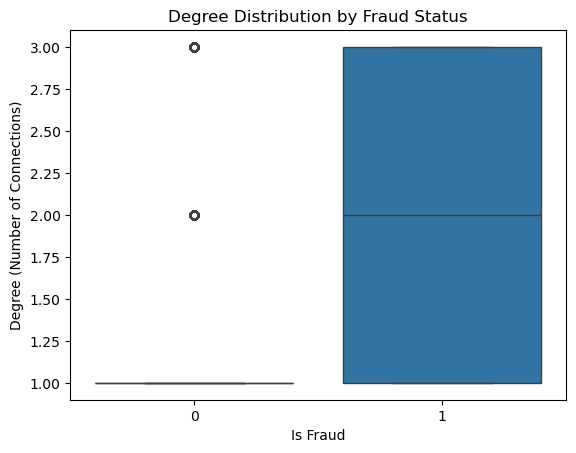

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='isFraud', y='degree', data=pd.DataFrame({
    'degree': fraud_degrees + legit_degrees,
    'isFraud': [1]*len(fraud_degrees) + [0]*len(legit_degrees)
}))

plt.title('Degree Distribution by Fraud Status')
plt.xlabel('Is Fraud')
plt.ylabel('Degree (Number of Connections)')
plt.show()
